In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
from sklearn.base import clone

RANDOM_STATE = 42

train_path = 'mai-ml-lab-2-fiit-2025/train_c.csv'
test_path  = 'mai-ml-lab-2-fiit-2025/test_c.csv'
submission_path = 'submission_lab2.csv'

def safe_log1p_ser(s):
    s = pd.to_numeric(s, errors='coerce').copy()
    if s.isnull().all():
        return s
    mn = s.min(skipna=True)
    if pd.notna(mn) and mn < 0:
        shift = abs(mn) + 1.0
        return np.log1p(s + shift)
    else:
        return np.log1p(s.fillna(0))

if not os.path.exists(train_path):
    raise FileNotFoundError(f"Train file not found at {train_path}")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path) if os.path.exists(test_path) else None
print("Loaded. Train:", train_df.shape, "Test present:", test_df is not None)

def preprocess_base(df, is_train=True):
    df = df.copy()
    if is_train and 'LoanApproved' in df.columns:
        df = df[df['LoanApproved'].isin([0,1]) | df['LoanApproved'].isna()] if 'LoanApproved' in df.columns else df
    df.replace(-9999999.0, np.nan, inplace=True)
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['App_Year'] = df['ApplicationDate'].dt.year.fillna(0).astype(int)
        df['App_Month'] = df['ApplicationDate'].dt.month.fillna(0).astype(int)
        df['App_DayOfWeek'] = df['ApplicationDate'].dt.dayofweek.fillna(0).astype(int)
    eps = 1e-6
    if 'MonthlyLoanPayment' in df.columns and 'MonthlyIncome' in df.columns:
        df['PaymentToIncomeRatio'] = df['MonthlyLoanPayment'] / (df['MonthlyIncome'] + eps)
    if 'LoanAmount' in df.columns and 'AnnualIncome' in df.columns:
        df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['AnnualIncome'] + eps)
    if 'TotalLiabilities' in df.columns and 'TotalAssets' in df.columns:
        df['DebtToAssetsRatio'] = df['TotalLiabilities'] / (df['TotalAssets'] + eps)
    if 'SavingsAccountBalance' in df.columns and 'LoanAmount' in df.columns:
        df['SavingsToLoanRatio'] = df['SavingsAccountBalance'] / (df['LoanAmount'] + eps)
    if 'LengthOfCreditHistory' in df.columns and 'PaymentHistory' in df.columns:
        df['CreditHistoryInteraction'] = df['LengthOfCreditHistory'] * df['PaymentHistory']
    if 'MonthlyIncome' in df.columns and 'CreditScore' in df.columns:
        df['Income_x_CreditScore'] = df['MonthlyIncome'].fillna(0) * df['CreditScore'].fillna(0)
    clip_cols = ['MonthlyIncome','LoanAmount','AnnualIncome','SavingsAccountBalance','TotalAssets','TotalLiabilities','MonthlyDebtPayments']
    for c in clip_cols:
        if c in df.columns:
            lo = df[c].quantile(0.01)
            hi = df[c].quantile(0.99)
            df[c] = df[c].clip(lo, hi)
    log_candidates = ['MonthlyIncome','LoanAmount','SavingsAccountBalance','CheckingAccountBalance','TotalAssets','TotalLiabilities','NetWorth','MonthlyDebtPayments']
    for c in log_candidates:
        if c in df.columns:
            df[c] = safe_log1p_ser(df[c])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

train_proc = preprocess_base(train_df, is_train=True)
test_proc = preprocess_base(test_df, is_train=False) if test_df is not None else None

target_col = 'LoanApproved'
numerical_candidates = [
    'CreditScore','MonthlyIncome','BaseInterestRate','LoanAmount','LoanDuration',
    'DebtToIncomeRatio','NumberOfDependents','NumberOfOpenCreditLines','NumberOfCreditInquiries',
    'PaymentHistory','LengthOfCreditHistory','UtilityBillsPaymentHistory','MonthlyDebtPayments',
    'CreditCardUtilizationRate','InterestRate','TotalDebtToIncomeRatio','SavingsAccountBalance',
    'CheckingAccountBalance','TotalAssets','TotalLiabilities','NetWorth','JobTenure','Experience','Age',
    'BankruptcyHistory','PreviousLoanDefaults','PaymentToIncomeRatio','LoanToIncomeRatio','DebtToAssetsRatio',
    'SavingsToLoanRatio','CreditHistoryInteraction','Income_x_CreditScore','App_Year','App_Month','App_DayOfWeek'
]
numerical = [c for c in numerical_candidates if c in train_proc.columns]
categorical_candidates = ['MaritalStatus','HomeOwnershipStatus','EmploymentStatus','EducationLevel','LoanPurpose']
categorical = [c for c in categorical_candidates if c in train_proc.columns]
binned = [c for c in ['Age','CreditScore'] if c in train_proc.columns]

final_numerical = [c for c in numerical if c not in binned]
all_features = final_numerical + categorical + binned

def drop_high_corr(df, features, thresh=0.99):
    num_df = df[features].select_dtypes(include=[np.number]).copy()
    if num_df.shape[1] < 2:
        return []
    corr = num_df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thresh)]
    return to_drop

to_drop = drop_high_corr(train_proc, final_numerical, thresh=0.995)
if to_drop:
    final_numerical = [f for f in final_numerical if f not in to_drop]
    all_features = final_numerical + categorical + binned

print("Numeric features:", len(final_numerical), "Categorical:", len(categorical), "Binned:", binned)

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binned_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('bin', KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, final_numerical),
    ('cat', categorical_pipeline, categorical),
    ('bin', binned_pipeline, binned)
], remainder='drop')

train_proc = train_proc.dropna(subset=[target_col], how='any')
X = train_proc[all_features].copy()
y = train_proc[target_col].astype(int).copy()

if test_proc is not None:
    for c in all_features:
        if c not in test_proc.columns:
            test_proc[c] = np.nan


clf_lr = LogisticRegression(C=1.0, solver='saga', max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1)
clf_rf = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1, random_state=RANDOM_STATE)
clf_hgb = HistGradientBoostingClassifier(max_iter=300, random_state=RANDOM_STATE)

estimators = [
    ('lr', clf_lr),
    ('rf', clf_rf),
    ('hgb', clf_hgb)
]
final_meta = LogisticRegression(solver='liblinear', C=1.0, random_state=RANDOM_STATE)

pipe_stack = Pipeline([
    ('preproc', preprocessor),
    ('pre_var', SelectKBest(score_func=f_classif, k=min(800, max(10, len(final_numerical) + 100)))),
    ('stack', StackingClassifier(estimators=estimators, final_estimator=final_meta, n_jobs=-1, passthrough=False))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Starting cross-validated evaluation (5 folds)...")
oof_preds = np.zeros(len(X))
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    pipe = clone(pipe_stack)
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_val)[:,1]
    oof_preds[val_idx] = proba
    auc = roc_auc_score(y_val, proba)
    ap = average_precision_score(y_val, proba)
    print(f"Fold {fold} | ROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f}")

cv_auc = roc_auc_score(y, oof_preds)
cv_pr = average_precision_score(y, oof_preds)
print(f"\nOOF CV ROC-AUC: {cv_auc:.4f}")
print(f"OOF CV PR-AUC: {cv_pr:.4f}")

y_pred_bin = (oof_preds >= 0.5).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred_bin, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

print("\nTraining final model on full train...")
pipe_stack.fit(X, y)

if test_proc is not None:
    X_test = test_proc[all_features].copy()
    preds_test_proba = pipe_stack.predict_proba(X_test)[:,1]
    preds_test_proba = np.clip(preds_test_proba, 0.0, 1.0)
    if 'ID' in test_proc.columns:
        sub = pd.DataFrame({'ID': test_proc['ID'], 'LoanApproved': preds_test_proba})
    else:
        sub = pd.DataFrame({'LoanApproved': preds_test_proba})
    sub.to_csv(submission_path, index=False)
    print("Saved submission to:", submission_path)



Loaded. Train: (11017, 35) Test present: True
Numeric features: 33 Categorical: 5 Binned: ['Age', 'CreditScore']
Starting cross-validated evaluation (5 folds)...
Fold 1 | ROC-AUC: 0.9828 | PR-AUC: 0.9840
Fold 2 | ROC-AUC: 0.9845 | PR-AUC: 0.9857
Fold 3 | ROC-AUC: 0.9844 | PR-AUC: 0.9858
Fold 4 | ROC-AUC: 0.9846 | PR-AUC: 0.9856
Fold 5 | ROC-AUC: 0.9851 | PR-AUC: 0.9861

OOF CV ROC-AUC: 0.9842
OOF CV PR-AUC: 0.9854
Precision: 0.9349, Recall: 0.9370, F1: 0.9360

Training final model on full train...
Saved submission to: submission_lab2.csv

Done. Если ROC-AUC (OOF) < 0.75, рекомендую:
  • увеличить SelectKBest (k), попробовать passthrough=True в StackingClassifier,
  • тонкая настройка RandomForest (max_depth, n_estimators) или замена HGB на LightGBM,
  • добавить дополнительные interaction-признаки или использовать target-encoding для категорий.


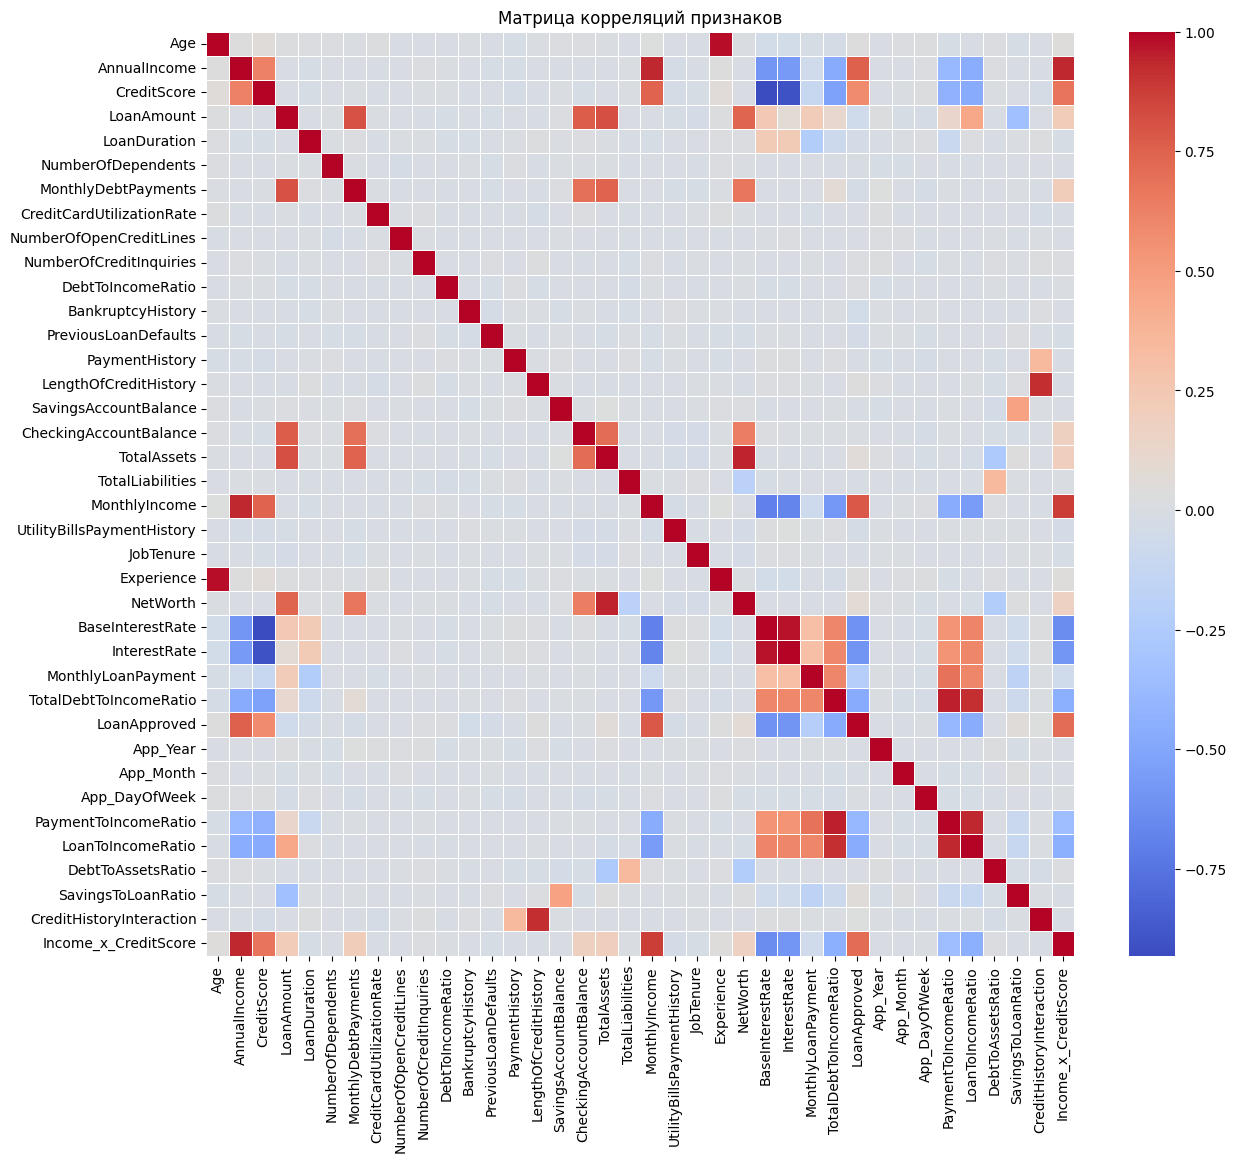

Топ корреляций с целевой переменной (LoanApproved):
LoanApproved              1.000000
MonthlyIncome             0.782673
AnnualIncome              0.754224
Income_x_CreditScore      0.710081
BaseInterestRate          0.605164
InterestRate              0.599180
CreditScore               0.581812
TotalDebtToIncomeRatio    0.476222
LoanToIncomeRatio         0.469747
PaymentToIncomeRatio      0.391517
Name: LoanApproved, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_data = train_proc.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 12))
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Матрица корреляций признаков")
plt.show()

print("Топ корреляций с целевой переменной (LoanApproved):")
print(correlation_matrix['LoanApproved'].abs().sort_values(ascending=False).head(10))

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import optuna

try:
    X_manual_train = X.toarray() if hasattr(X, 'toarray') else X
except NameError:
    X_manual_train = X_trans.toarray() if hasattr(X_trans, 'toarray') else X_trans
    
y_manual_train = y

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_manual_train, y_manual_train, test_size=0.3, random_state=42
)
print("Данные для ручной реализации подготовлены.")

Данные для ручной реализации подготовлены.


In [ ]:
def custom_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def custom_precision_recall_f1(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    return precision, recall, f1

def custom_auc_roc(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    return np.trapz(tpr, fpr)

def custom_auc_pr(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    return np.trapz(precision, recall)

X_train_transformed = preprocessor.fit_transform(train_proc[all_features])
X_val_transformed = preprocessor.transform(train_proc[all_features])

from sklearn.model_selection import train_test_split
y = train_proc[target_col].dropna()
X_transformed = preprocessor.fit_transform(train_proc.loc[y.index, all_features])

X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

model_test = lgb.LGBMClassifier(random_state=42)
model_test.fit(X_train_t, y_train_t)
preds_proba = model_test.predict_proba(X_val_t)[:, 1]
preds_binary = (preds_proba >= 0.5).astype(int)

prec, rec, f1 = custom_precision_recall_f1(y_val_t, preds_binary)

print("\n--- Тест Метрик ---")
print(f"Accuracy: {custom_accuracy(y_val_t, preds_binary):.4f} (Custom) vs {accuracy_score(y_val_t, preds_binary):.4f} (Sklearn)")
print(f"Precision: {prec:.4f} (Custom) vs {precision_score(y_val_t, preds_binary):.4f} (Sklearn)")
print(f"Recall: {rec:.4f} (Custom) vs {recall_score(y_val_t, preds_binary):.4f} (Sklearn)")
print(f"F1-score: {f1:.4f} (Custom) vs {f1_score(y_val_t, preds_binary):.4f} (Sklearn)")
print(f"AUC-ROC: {custom_auc_roc(y_val_t, preds_proba):.4f} (Custom) vs {roc_auc_score(y_val_t, preds_proba):.4f} (Sklearn)")
print(f"AUC-PR: {custom_auc_pr(y_val_t, preds_proba):.4f} (Custom) vs {average_precision_score(y_val_t, preds_proba):.4f} (Sklearn)")


[LightGBM] [Info] Number of positive: 4293, number of negative: 4096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5427
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511742 -> initscore=0.046975
[LightGBM] [Info] Start training from score 0.046975

--- Тест Метрик ---
Accuracy: 0.9261 (Custom) vs 0.9261 (Sklearn)
Precision: 0.9290 (Custom) vs 0.9290 (Sklearn)
Recall: 0.9264 (Custom) vs 0.9264 (Sklearn)
F1-score: 0.9277 (Custom) vs 0.9277 (Sklearn)
AUC-ROC: 0.9826 (Custom) vs 0.9826 (Sklearn)
AUC-PR: -0.9842 (Custom) vs 0.9842 (Sklearn)


In [ ]:
class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators_ = []
        self.initial_pred = 0

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        
    def fit(self, X, y):
        p_avg = np.mean(y)
        self.initial_pred = np.log(p_avg / (1 - p_avg + 1e-10))
        F_m = np.full_like(y, self.initial_pred, dtype=float)
        
        for m in range(self.n_estimators):
            p = self._sigmoid(F_m)
            residuals = y - p
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residuals)
            self.estimators_.append(tree)
            
            h_m = tree.predict(X)
            F_m += self.learning_rate * h_m
            
        return self

    def predict_proba(self, X):
        F_M = np.full(X.shape[0], self.initial_pred)
        
        for tree in self.estimators_:
            F_M += self.learning_rate * tree.predict(X)
            
        proba_1 = self._sigmoid(F_M)
        proba_0 = 1 - proba_1
        return np.vstack([proba_0, proba_1]).T

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

print("\n--- Тест Градиентного Бустинга (Custom vs Sklearn) ---")

gb_custom = MyGradientBoostingClassifier(n_estimators=10, learning_rate=0.5, max_depth=2)
gb_custom.fit(X_train_t, y_train_t)
preds_custom = gb_custom.predict(X_val_t)
proba_custom = gb_custom.predict_proba(X_val_t)[:, 1]
print(f"Custom GB Accuracy: {accuracy_score(y_val_t, preds_custom):.4f}")
print(f"Custom GB ROC-AUC: {roc_auc_score(y_val_t, proba_custom):.4f}")

gb_sklearn = GradientBoostingClassifier(n_estimators=10, learning_rate=0.5, max_depth=2, random_state=42)
gb_sklearn.fit(X_train_t, y_train_t)
preds_sklearn = gb_sklearn.predict(X_val_t)
proba_sklearn = gb_sklearn.predict_proba(X_val_t)[:, 1]
print(f"Sklearn GB Accuracy: {accuracy_score(y_val_t, preds_sklearn):.4f}")
print(f"Sklearn GB ROC-AUC: {roc_auc_score(y_val_t, proba_sklearn):.4f}")



--- Тест Градиентного Бустинга (Custom vs Sklearn) ---
Custom GB Accuracy: 0.8980
Custom GB ROC-AUC: 0.9658
Sklearn GB Accuracy: 0.9133
Sklearn GB ROC-AUC: 0.9756


In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1,
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = lgb.LGBMClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_index, val_index in kf.split(X_transformed, y):
        X_tr, X_val = X_transformed[train_index], X_transformed[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  eval_metric='auc',
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        
        preds = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, preds))
        
    return np.mean(auc_scores)

print("\n--- Оптимизация гиперпараметров с Optuna ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True) 

print("\nЛучшая ROC-AUC на кросс-валидации:", study.best_value)
print("Лучшие гиперпараметры:", study.best_params)


[I 2025-12-07 21:09:57,706] A new study created in memory with name: no-name-91606678-3857-433b-b4a2-67f4c1300318



--- Оптимизация гиперпараметров с Optuna ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-07 21:09:59,971] Trial 0 finished with value: 0.9805711331297043 and parameters: {'n_estimators': 80, 'learning_rate': 0.028490195188234625, 'max_depth': 8, 'num_leaves': 100, 'feature_fraction': 0.7410046023961652, 'bagging_fraction': 0.7221790710755762, 'bagging_freq': 3, 'lambda_l1': 4.307150753709403, 'lambda_l2': 7.248544149676788e-08}. Best is trial 0 with value: 0.9805711331297043.
[I 2025-12-07 21:10:01,726] Trial 1 finished with value: 0.9806606343682043 and parameters: {'n_estimators': 69, 'learning_rate': 0.011952646839944592, 'max_depth': 6, 'num_leaves': 41, 'feature_fraction': 0.8084798885158443, 'bagging_fraction': 0.5032088127662818, 'bagging_freq': 1, 'lambda_l1': 5.0625580330301184e-08, 'lambda_l2': 1.085350937063122e-08}. Best is trial 1 with value: 0.9806606343682043.
[I 2025-12-07 21:10:12,163] Trial 2 finished with value: 0.9846665049256901 and parameters: {'n_estimators': 293, 'learning_rate': 0.036845310199099916, 'max_depth': 7, 'num_leaves': 89, 'fe